In [1]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/FeedRecSys

/content/drive/My Drive/FeedRecSys


In [3]:
!pip install faiss-cpu   # use only these installs, it works
# !pip install faiss-gpu


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.6 MB 38.3 MB/s 


In [4]:
# all imports must go here
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import shutil
import glob
import random
import cv2 as cv
import sys
import pickle

import faiss
import time

In [ ]:
def getFeatureVector(model, img_path):
  # print("imag_path=",img_path )
  img = cv.imread(img_path)
  img = cv.resize(img, (224, 224))
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  feature_vector = model.predict(img.reshape(1, 224, 224, 3))

  # print(img_path + " is added.")
  return feature_vector


In [ ]:
# res = faiss.StandardGpuResources()  # use a single GPU

In [5]:

# train_dict = pickle.load(open('train_embed.pickle', 'rb'))
# valid_dict = pickle.load(open('valid_embed.pickle', 'rb'))

train_dict = pickle.load(open('trainxception_embed.pickle', 'rb'))

In [ ]:
train_dict

In [ ]:
documents = []
vectors = []
for k,v in train_dict.items():
  # print(v[0])
  documents.append(k)
  vectors.append(v)
len(documents),len(vectors)

print(type(vectors))

array_vec = np.squeeze(np.asarray(vectors), axis=1)
print(array_vec.shape)



<class 'list'>
(16032, 2048)


In [ ]:
index = faiss.IndexIDMap(faiss.IndexFlatIP(2048))
# encoded_data.shape
ids = np.array(range(0, len(documents)))

index.add_with_ids(array_vec, ids )

faiss.write_index(index, 'incepimgsearch')

incepimgsearch_index = faiss.read_index('incepimgsearch')

In [ ]:
# gpu_index = faiss.index_cpu_to_gpu(res, 0, so_index)

In [ ]:
chunk = faiss.serialize_index(incepimgsearch_index)
with open("faiss_index.pkl", "wb") as f:
    pickle.dump(chunk, f)

In [ ]:
train_dict['B075BN7TXM.jpeg']

array([[ 0.2960275 ,  0.22923818, -0.02728606, ...,  0.12552433,
        -0.12958549, -0.364016  ]], dtype=float32)

In [ ]:
incepimgsearch_index = faiss.deserialize_index(chunk)

In [ ]:
def search(query):
   t=time.time()
   query_vector = train_dict[query]
   k = 10
   top_k = incepimgsearch_index.search(query_vector, k)
   print('totaltime: {}'.format(time.time()-t))
   return [documents[_id] for _id in top_k[1].tolist()[0]]

In [ ]:
query=str(input())
results=search(query)
print('results :')
for result in results:
   print('\t',result)

B07571NV1Z.jpeg
totaltime: 0.05117464065551758
results :
	 B07571NV1Z.jpeg
	 B072QS773R.jpeg
	 B00KXSLEKY.jpeg
	 B01LXH4VBS.jpeg
	 B06Y3CJJ9P.jpeg
	 B01LYS9NAQ.jpeg
	 B014PMMKGU.jpeg
	 B00VVC9MZA.jpeg
	 B075BPCS6X.jpeg
	 B071SD9C32.jpeg


In [ ]:
#B07571NV1Z.jpeg

	#  B07571NV1Z.jpeg
	#  B071K71HXS.jpeg
	#  B01MRRRNMS.jpeg
	#  B074NBXX3J.jpeg
	#  B01IPVOU9W.jpeg

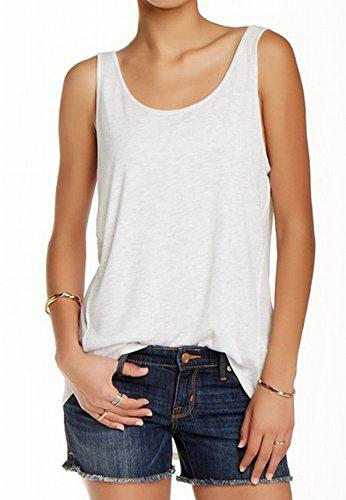

In [ ]:
from google.colab.patches import cv2_imshow
img = cv.imread(os.path.join('/content/drive/My Drive/FeedRecSys/16k_images', 'B07571NV1Z.jpeg' ), cv.IMREAD_COLOR)
 
cv2_imshow(img)

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
 
for result in results:
  print(result)
  img = cv2.imread(os.path.join('/content/drive/My Drive/FeedRecSys/16k_images', result ), cv2.IMREAD_COLOR)
 

  cv2_imshow(img)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
nlist = 100
d = 2048
m = 8
k = 4
quantizer = faiss.IndexFlatL2(d)  # this remains the same
ivfpq_index = faiss.IndexIVFPQ(quantizer, d, nlist, m, 8)
                                  # 8 specifies that each sub-vector is encoded as 8 bits
ivfpq_index.train(array_vec)
ivfpq_index.add(array_vec)
# D, I = index.search(array_vec[:5], k) # sanity check
# print(I)
# print(D)


In [ ]:
# !rm -r faiss_ivfpqindex.pkl

In [ ]:
ivfpq = faiss.serialize_index(ivfpq_index)
with open("faiss_ivfpqindex.pkl", "wb") as f:
    pickle.dump(ivfpq, f)


In [ ]:
# ivfpq_index = faiss.deserialize_index(ivfpq)

In [ ]:
def search(query):
  t =time.time()
  query_vector = train_dict[query]
  k = 5
  #  top_k = gpu_index.search(query_vector, k)
  print(type(query_vector))

  print(query_vector.shape)
  D, I = ivfpq_index.search(query_vector, k) # sanity check
  print("top_k=",D)
  print('totaltime: {}'.format(time.time()-t))
  return [documents[_id] for _id in I.tolist()[0]]

In [ ]:
query=str(input())
results=search(query)
print('results :')
for result in results:
   print('\t',result)

B074VWLBMV.jpeg
<class 'numpy.ndarray'>
(1, 2048)
top_k= [[17.621943 17.621943 18.412342 18.697144 19.225327]]
totaltime: 0.0057523250579833984
results :
	 B074VWLBMV.jpeg
	 B074VMNZN9.jpeg
	 B013Y5CIGG.jpeg
	 B01D43BBWA.jpeg
	 B018U3B70U.jpeg


B074VWLBMV.jpeg

B074VWLBMV.jpeg
<class 'numpy.ndarray'>
(1, 2048)
top_k= [[17.621943 17.621943 18.412342 18.697144 19.225327]]
totaltime: 0.005444049835205078
results :
	 B074VWLBMV.jpeg
	 B074VMNZN9.jpeg
	 B013Y5CIGG.jpeg
	 B01D43BBWA.jpeg
	 B018U3B70U.jpeg

B074VWLBMV.jpeg


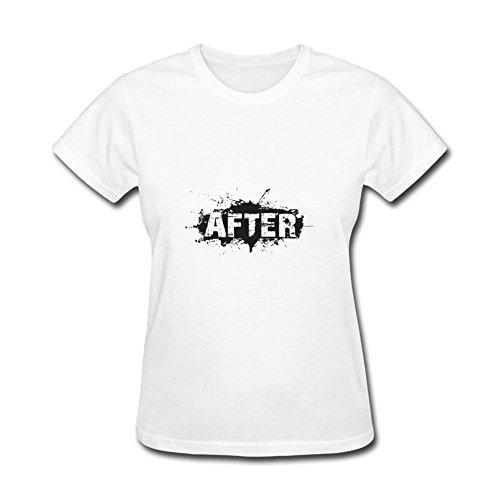

B074VMNZN9.jpeg


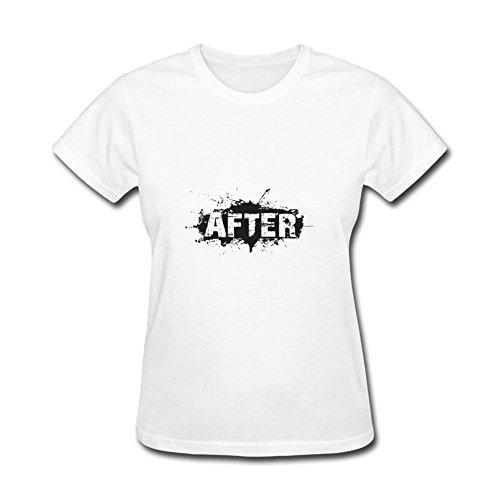

B013Y5CIGG.jpeg


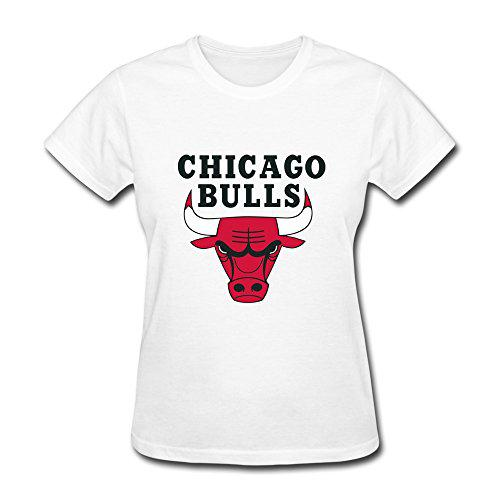

B01D43BBWA.jpeg


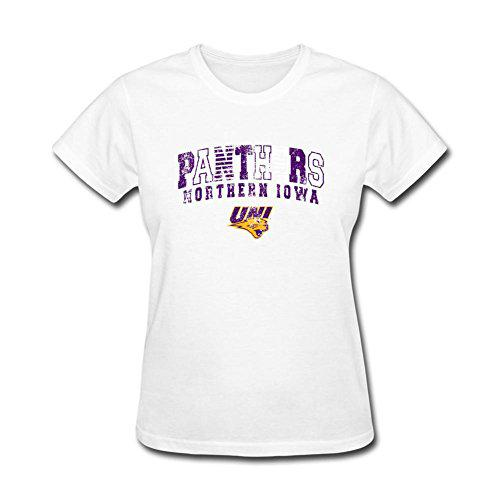

B018U3B70U.jpeg


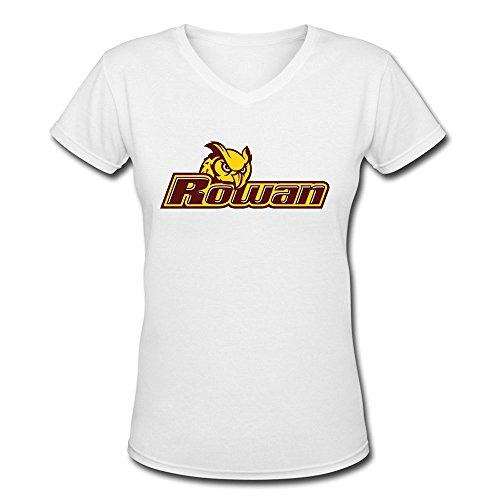

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
for result in results:
  print(result)
  img = cv2.imread(os.path.join('/content/drive/My Drive/FeedRecSys/train', result ), cv2.IMREAD_COLOR)
 

  cv2_imshow(img)


In [ ]:
query=str(input())
results=search(query)
print('results :')
for result in results:
   print('\t',result)

B074SVRF7S.jpeg
<class 'numpy.ndarray'>
(1, 2048)
top_k= [[42.038868 47.174652 48.352375 50.143623 50.196507]]
totaltime: 0.0055217742919921875
results :
	 B074SVRF7S.jpeg
	 B074MJ345F.jpeg
	 B074P91YZ8.jpeg
	 B06XXMRXW6.jpeg
	 B01N3OXLYQ.jpeg


B074SVRF7S.jpeg


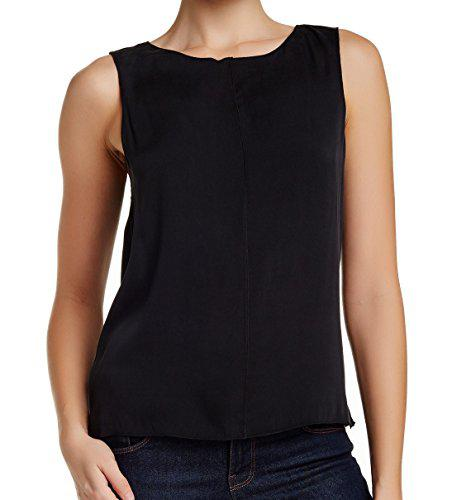

B074MJ345F.jpeg


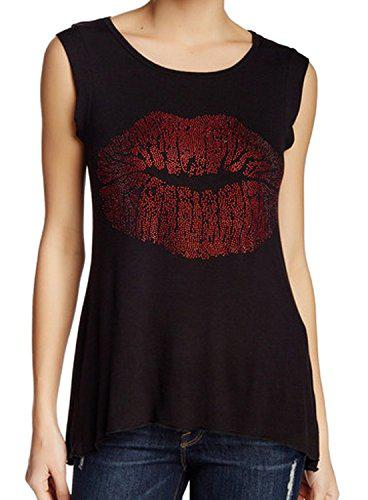

B074P91YZ8.jpeg


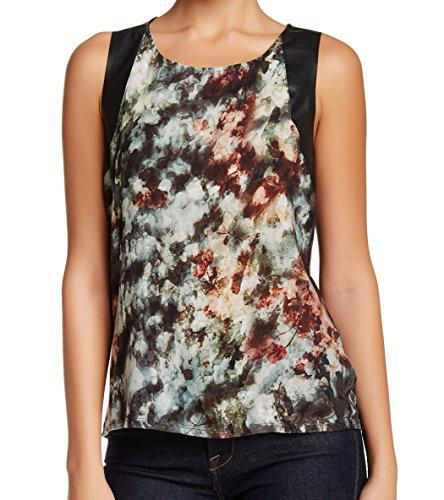

B06XXMRXW6.jpeg


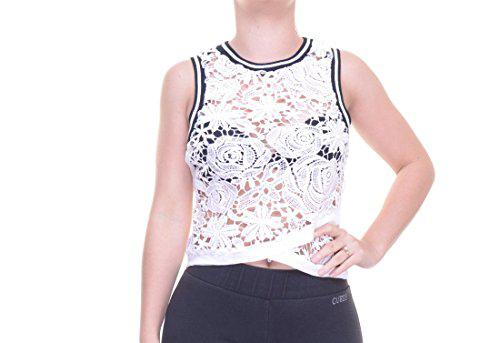

B01N3OXLYQ.jpeg


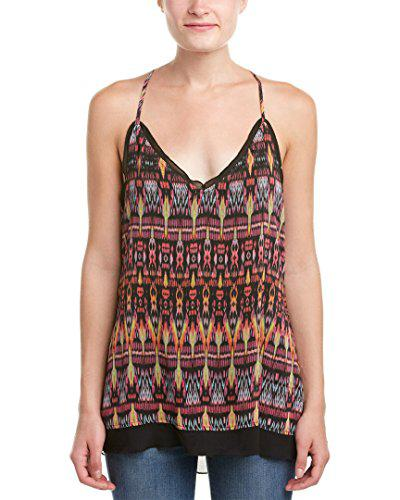

In [ ]:
for result in results:
  print(result)
  img = cv2.imread(os.path.join('/content/drive/My Drive/FeedRecSys/16k_images', result ), cv2.IMREAD_COLOR)
 

  cv2_imshow(img)

In [ ]:
n_bits = 2 * 2048
index_lsh = faiss.IndexIDMap(faiss.IndexLSH(2048, n_bits))
# encoded_data.shape
ids = np.array(range(0, len(documents)))

index_lsh.add_with_ids(array_vec, ids )

faiss.write_index(index_lsh, 'incepimglshsearch')

incepimgsearch_index = faiss.read_index('incepimglshsearch')

In [ ]:
lshIndex = faiss.IndexLSH(2048, 2 * 2048)

input_features = np.ascontiguousarray(np.asarray(array_vec, "float32"))
lshIndex.add(input_features)
# lshIndex.search(np.asarray([input_features[0]], "float32"), 10)

(array([[  0., 739., 740., 769., 770., 788., 802., 807., 807., 813.]],
       dtype=float32),
 array([[    0,  3291,  3121, 14957,  1926,  7405,  6059,   506,  2531,
         12692]]))

In [ ]:
def search(query):
   t=time.time()
   query_vector = train_dict[query]
   k = 5
   top_k = lshIndex.search(np.asarray([query_vector[0]], "float32"), k)
  #  top_k = incepimgsearch_index.search(query_vector, k)
   print('totaltime: {}'.format(time.time()-t))
   return [documents[_id] for _id in top_k[1].tolist()[0]]

In [ ]:
query=str(input())
results=search(query)
print('results :')
for result in results:
   print('\t',result)

B075BN7TXM.jpeg
totaltime: 0.022543668746948242
results :
	 B075BN7TXM.jpeg
	 B01LZKACOY.jpeg
	 B01N8027IB.jpeg
	 B01CEUX0MI.jpeg
	 B01NBWQJFM.jpeg


B075BN7TXM.jpeg


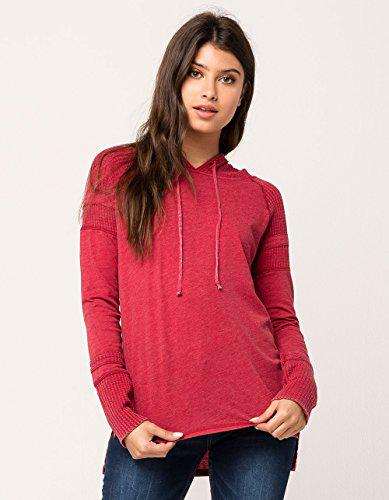

B01LZKACOY.jpeg


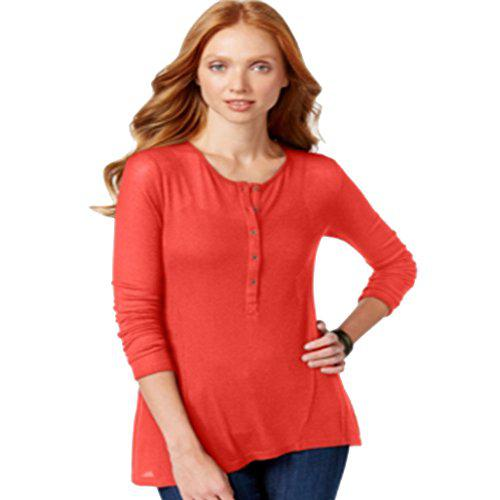

B01N8027IB.jpeg


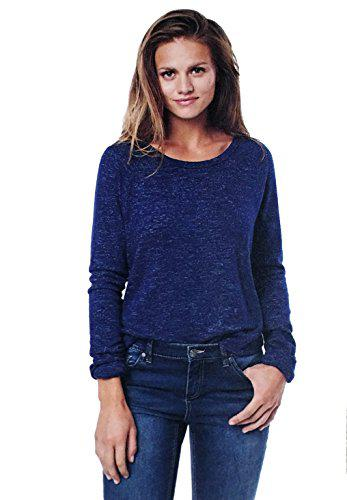

B01CEUX0MI.jpeg


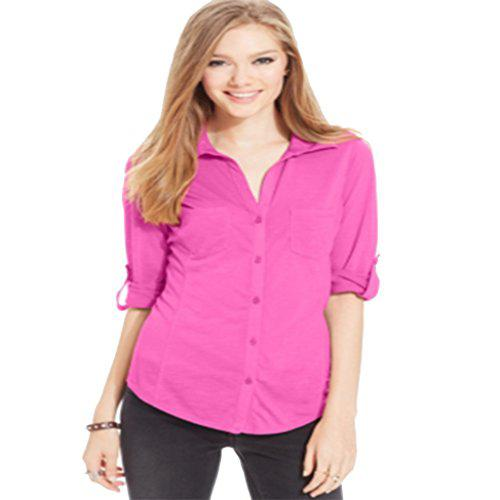

B01NBWQJFM.jpeg


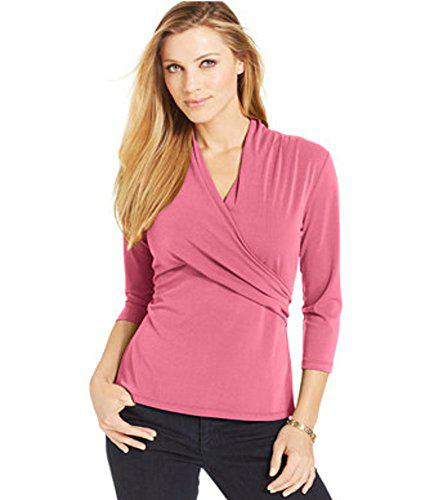

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
for result in results:
  print(result)
  img = cv2.imread(os.path.join('/content/drive/My Drive/FeedRecSys/16k_images', result ), cv2.IMREAD_COLOR)
 

  cv2_imshow(img)